# Solution Part III

## 0. Basic Steps

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression, ElasticNet, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
df = pd.read_csv('clean_data.csv', index_col='user_id')

In [3]:
X = df.drop('class',axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=100, stratify=y)

## 1. First model

In [4]:
cat_cols = X_train.columns[X_train.dtypes=='object'].to_list()

In [5]:
num_cols = [x for x in X_train.columns if x not in cat_cols]

In [6]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(X[self.columns])
    
    def fit(self, X, *_):
        return self


In [7]:
pipe_num = Pipeline(
    [
        ("select", ColumnSelector(num_cols)),
        ("scale", MinMaxScaler())
    ]
)

In [8]:
pipe_cat = Pipeline(
    [
        ("select", ColumnSelector(cat_cols)),
        ("ohe", OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [9]:
union = FeatureUnion(
    [
        ("numeric", pipe_num),
        ("categoric", pipe_cat),
    ]
)

In [10]:
full_pipe = Pipeline(
    [
        ("preprocessing", union),
        ("clf", None)
    ]
)

In [11]:
param_grid = [
#     {
#         "clf": [ElasticNet()], 
#         "clf__alpha": [np.logspace(-3, 2, 7)], 
#         "clf__l1_ratio": [0.2, 0.5, 0.9]
#     },
    {
        "clf": [CatBoostClassifier()],
        "clf__n_estimators": [50, 200, 500],
        "clf__depth": [None, 1, 2, 3]
    }
]

In [22]:
cat = CatBoostClassifier(n_estimators=50, verbose=False)
cat.fit(full_pipe.fit_transform(X_train), y_train)

In [30]:
y_hat_train = cat.predict(full_pipe.transform(X_train))
y_hat_test = cat.predict(full_pipe.transform(X_test))

In [31]:
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       418
           1       0.97      0.99      0.98       481

    accuracy                           0.98       899
   macro avg       0.98      0.98      0.98       899
weighted avg       0.98      0.98      0.98       899



In [32]:
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.76      0.83      0.79        46
           1       0.84      0.78      0.81        54

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100



In [45]:
known_cols = [x for x in X_train.columns[:-4]]
cat_cols_names =  [f'cat_{i}' for i in range(len(cat.feature_names_)-len(known_cols))] 

features = pd.Series(cat.feature_importances_, index=known_cols + cat_cols_names).sort_values(ascending=False)

<AxesSubplot:>

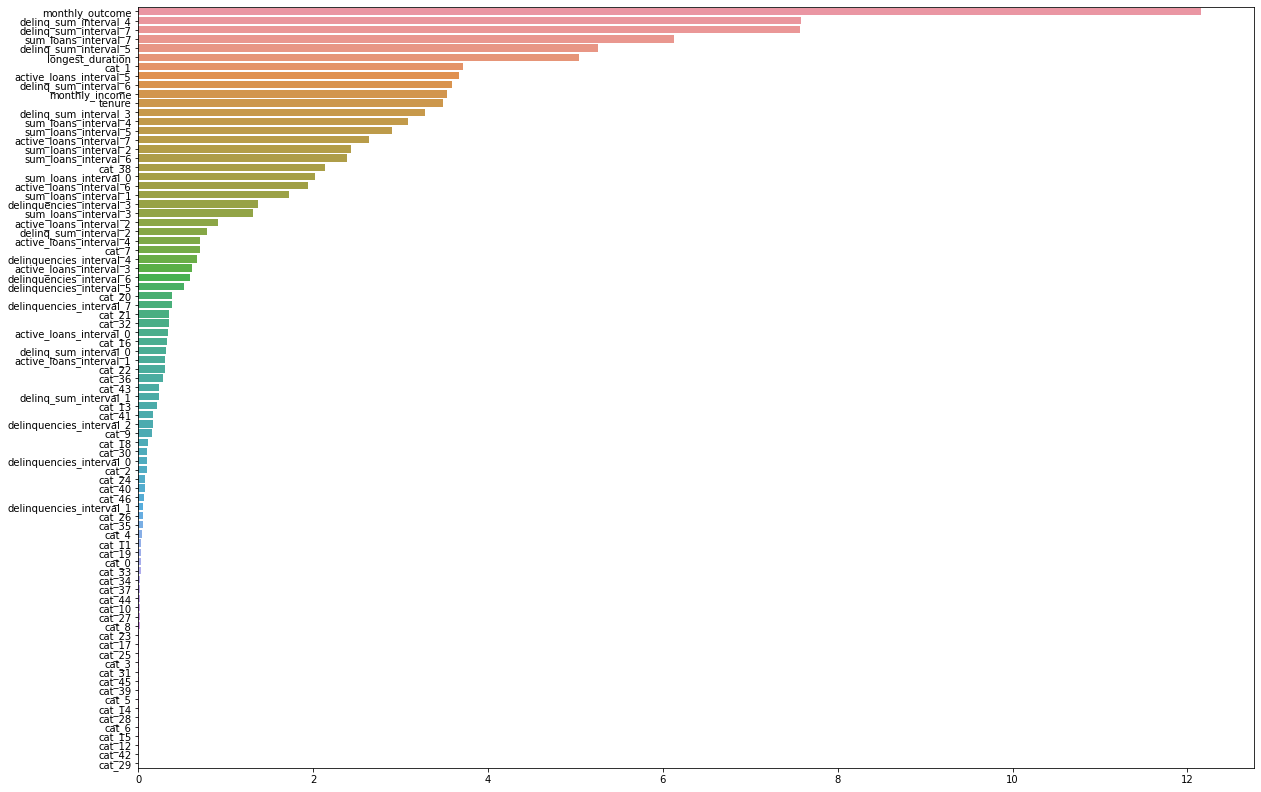

In [47]:
plt.figure(figsize=(20,14))
sns.barplot(x=features.values, y=features.index)

### Thoughts
- I know I shouldn't go for a Gradient Boosting model as my first choice, but I did it due to the time constraints and ease of use.
- The model in question is currently overfitting a bit, but I will still use it for answering the questions asked.
- Most of the categorical features appear to be useless, and the ones that seem to be useful might be due to the previously mentioned overfit.

## 2. Answering the questions
**Meaningless disclaimer:** This is the first time I work with this kind of data and much of the time I spent researching how to define the metrics, interest rates, amounts, etc. That being said, I found this metric on the web, so credits to the author.

You can find the original article here:
https://www.listendata.com/2019/07/KS-Statistics-Python.html

In [48]:
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    
    #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

In [57]:
y_proba = pd.DataFrame(cat.predict_proba(full_pipe.transform(X_train)), columns=['bad', 'good'], index=X_train.index)
y_proba = pd.concat([y_proba, y_train], axis=1)

In [61]:
ks(y_proba, target='class', prob='good')

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.981564  0.999687      90          0     18.71%         0.00%   
2       0.957714  0.981282      90          0     18.71%         0.00%   
3       0.921072  0.957455      90          0     18.71%         0.00%   
4       0.848770  0.920845      89          1     18.50%         0.24%   
5       0.714081  0.848582      86          3     17.88%         0.72%   
6       0.260465  0.713956      36         54      7.48%        12.92%   
7       0.104583  0.258661       0         90      0.00%        21.53%   
8       0.043283  0.102436       0         90      0.00%        21.53%   
9       0.013457  0.043094       0         90      0.00%        21.53%   
10      0.000557  0.013424       0         90      0.00%        21.53%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             18.71

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.981564,0.999687,90,0,18.71%,0.00%,18.71%,0.00%,18.7
2,0.957714,0.981282,90,0,18.71%,0.00%,37.42%,0.00%,37.4
3,0.921072,0.957455,90,0,18.71%,0.00%,56.13%,0.00%,56.1
4,0.848770,0.920845,89,1,18.50%,0.24%,74.64%,0.24%,74.4
5,0.714081,0.848582,86,3,17.88%,0.72%,92.52%,0.96%,91.6
6,0.260465,0.713956,36,54,7.48%,12.92%,100.00%,13.88%,86.1
7,0.104583,0.258661,0,90,0.00%,21.53%,100.00%,35.41%,64.6
8,0.043283,0.102436,0,90,0.00%,21.53%,100.00%,56.94%,43.1
9,0.013457,0.043094,0,90,0.00%,21.53%,100.00%,78.47%,21.5
